<a href="https://colab.research.google.com/github/Utkarsh87/Beginner-CNN-Projects/blob/master/Plant_disease_recognition_on_low_res_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This project was done as a part of the AICrowd Blitz 2020 competition.

https://www.aicrowd.com/challenges/aicrowd-blitz-may-2020/problems/minileaves

This was my first entry for this problem and it achieved a 0.977 F1 score and 0.984 accuracy score and was the 3rd best submission at the time of writing.

https://www.aicrowd.com/challenges/aicrowd-blitz-may-2020/problems/minileaves/submissions/63818

In [0]:
import numpy as np
import pandas as pd
import sklearn

In [32]:
#Donwload the datasets
!wget https://s3.eu-central-1.wasabisys.com/aicrowd-practice-challenges/public/minileaves/v0.1/train-images.npy
!wget https://s3.eu-central-1.wasabisys.com/aicrowd-practice-challenges/public/minileaves/v0.1/train-labels.npy
!wget https://s3.eu-central-1.wasabisys.com/aicrowd-practice-challenges/public/minileaves/v0.1/test-images.npy
!wget https://s3.eu-central-1.wasabisys.com/aicrowd-practice-challenges/public/minileaves/v0.1/all_classes.txt

--2020-05-05 16:49:57--  https://s3.eu-central-1.wasabisys.com/aicrowd-practice-challenges/public/minileaves/v0.1/train-images.npy
Resolving s3.eu-central-1.wasabisys.com (s3.eu-central-1.wasabisys.com)... 130.117.252.12, 130.117.252.11, 130.117.252.10, ...
Connecting to s3.eu-central-1.wasabisys.com (s3.eu-central-1.wasabisys.com)|130.117.252.12|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133527680 (127M) [binary/octet-stream]
Saving to: ‘train-images.npy.1’

train-images.npy.1  100%[===================>] 127.34M  27.7MB/s    in 5.5s    

2020-05-05 16:50:03 (23.4 MB/s) - ‘train-images.npy.1’ saved [133527680/133527680]

--2020-05-05 16:50:05--  https://s3.eu-central-1.wasabisys.com/aicrowd-practice-challenges/public/minileaves/v0.1/train-labels.npy
Resolving s3.eu-central-1.wasabisys.com (s3.eu-central-1.wasabisys.com)... 130.117.252.12, 130.117.252.11, 130.117.252.10, ...
Connecting to s3.eu-central-1.wasabisys.com (s3.eu-central-1.wasabisys.com)|130.11

Load the dataset

In [0]:
train_images = np.load('train-images.npy')
train_labels = np.load('train-labels.npy')
test_images = np.load('test-images.npy')

# Load the class-mapping to the images
class_names = [x.strip() for x in open("all_classes.txt").readlines()]

In [34]:
print("Train images: ", train_images.shape)
print("Train labels: ", train_labels.shape)
print("Test images: ", test_images.shape)
# print(train_images[0].shape) # each image is 32*32 pixels and 3 colour channels

# Cannot grayscale the images as the colour of the leaf might be one of the indicators of its health.

Train images:  (43466, 32, 32, 3)
Train labels:  (43466,)
Test images:  (10838, 32, 32, 3)


Map the classes to their class index

In [35]:
labels_map = {class_names[i]:i for i in range(len(class_names))}
inv_labels_map = {i:class_names[i] for i in range(len(class_names))}
print(labels_map)

{'apple-apple-scab': 0, 'apple-black-rot': 1, 'apple-cedar-apple-rust': 2, 'apple-healthy': 3, 'blueberry-healthy': 4, 'cherry-including-sour-healthy': 5, 'cherry-including-sour-powdery-mildew': 6, 'corn-maize-cercospora-leaf-spot-gray-leaf-spot': 7, 'corn-maize-common-rust': 8, 'corn-maize-healthy': 9, 'corn-maize-northern-leaf-blight': 10, 'grape-black-rot': 11, 'grape-esca-black-measles': 12, 'grape-healthy': 13, 'grape-leaf-blight-isariopsis-leaf-spot': 14, 'orange-haunglongbing-citrus-greening': 15, 'peach-bacterial-spot': 16, 'peach-healthy': 17, 'pepper-bell-bacterial-spot': 18, 'pepper-bell-healthy': 19, 'potato-early-blight': 20, 'potato-healthy': 21, 'potato-late-blight': 22, 'raspberry-healthy': 23, 'soybean-healthy': 24, 'squash-powdery-mildew': 25, 'strawberry-healthy': 26, 'strawberry-leaf-scorch': 27, 'tomato-bacterial-spot': 28, 'tomato-early-blight': 29, 'tomato-healthy': 30, 'tomato-late-blight': 31, 'tomato-leaf-mold': 32, 'tomato-septoria-leaf-spot': 33, 'tomato-spi

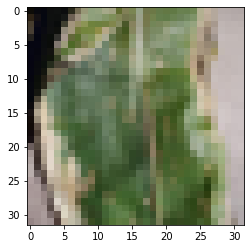

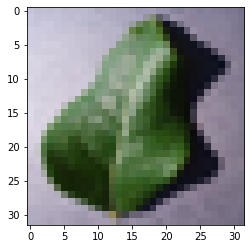

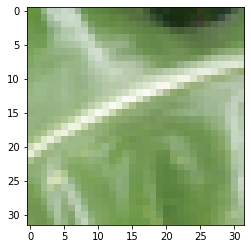

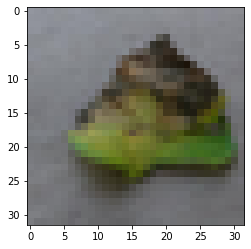

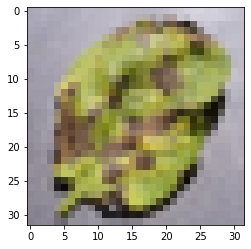

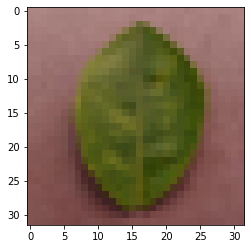

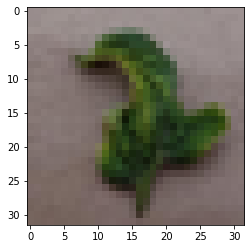

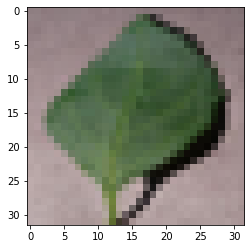

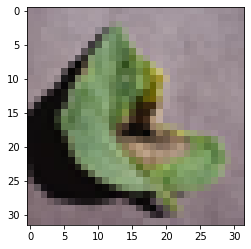

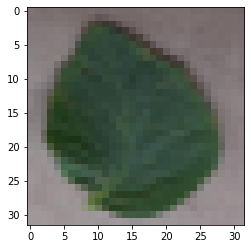

In [36]:
import matplotlib.pyplot as plt

# See the first few images
for i in range(10):
  plt.imshow(train_images[i])
  plt.show()

# We can clearly see the images are very low-resolution, as one would expect out of 32*32 images.

Convert labels to one-hot vectors(to be able to use the appropriate loss metrics)

In [0]:
from keras.utils import to_categorical   

train_labels = to_categorical(train_labels, num_classes=38)

Normalize the pixel values

In [0]:
train_images = train_images.astype(np.float32)/255.0

Separate out training and validation data

In [0]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.2, random_state = 42)

Perform some basic data augmentation

In [0]:
from keras.preprocessing.image import ImageDataGenerator

aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, 
    zoom_range=0.2,horizontal_flip=True, 
    fill_mode="nearest")

Define the model

In [0]:
from tensorflow.keras.layers import Conv2D, Flatten, Dropout, Dense, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Sequential

In [54]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='elu', padding='same', use_bias=True, input_shape=(32, 32, 3)))
# model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='elu', padding='same', use_bias=True))
# model.add(BatchNormalization())
# model.add(Conv2D(64, (3, 3), activation='elu', padding='same', use_bias=True))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.30))

model.add(Conv2D(64, (3, 3), activation='elu', padding='same', use_bias=True))
# model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation='elu', padding='same', use_bias=True))
# model.add(BatchNormalization())
# model.add(Conv2D(128, (3, 3), activation='elu', padding='same', use_bias=True))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.35))

model.add(Conv2D(128, (3, 3), activation='elu', padding='same', use_bias=True))
# model.add(BatchNormalization())
model.add(Conv2D(256, (3, 3), activation='elu', padding='same', use_bias=True))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.35))

model.add(Conv2D(512, (3, 3), activation='elu', padding='same', use_bias=True))
# model.add(BatchNormalization())
model.add(Conv2D(512, (3, 3), activation='elu', padding='same', use_bias=True))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.40))

model.add(Flatten())

model.add(Dense(512, activation='elu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(38, activation='softmax'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
batch_normalization_15 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 16, 16, 64)        36928     
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 16, 16, 128)      

In [0]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['mae', 'accuracy'])

In [0]:
epochs = 50
batch_size = 128
import tensorflow as tf
callbacks = [tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, mode='auto', min_lr=1e-5)]

Train the model

In [57]:
history = model.fit(aug.flow(x_train, y_train, batch_size=batch_size), callbacks=callbacks, epochs=epochs, steps_per_epoch=len(x_train) // batch_size, validation_data=(x_val, y_val))

Epoch 1/50
271/271 [==============================] - 18s 67ms/step - loss: 1.8644 - mae: 0.0309 - accuracy: 0.4979 - val_loss: 14.5184 - val_mae: 0.0505 - val_accuracy: 0.0360 - lr: 0.0010
Epoch 2/50
271/271 [==============================] - 18s 67ms/step - loss: 0.9709 - mae: 0.0201 - accuracy: 0.7049 - val_loss: 1.8390 - val_mae: 0.0235 - val_accuracy: 0.5820 - lr: 0.0010
Epoch 3/50
271/271 [==============================] - 18s 66ms/step - loss: 0.6819 - mae: 0.0152 - accuracy: 0.7843 - val_loss: 1.6314 - val_mae: 0.0222 - val_accuracy: 0.6044 - lr: 0.0010
Epoch 4/50
271/271 [==============================] - 18s 67ms/step - loss: 0.5227 - mae: 0.0121 - accuracy: 0.8340 - val_loss: 0.6393 - val_mae: 0.0128 - val_accuracy: 0.7996 - lr: 0.0010
Epoch 5/50
271/271 [==============================] - 18s 66ms/step - loss: 0.4297 - mae: 0.0102 - accuracy: 0.8624 - val_loss: 0.8597 - val_mae: 0.0152 - val_accuracy: 0.7559 - lr: 0.0010
Epoch 6/50
271/271 [==============================] - 

Text(0.5, 1.0, 'Training and Validaiton loss per epoch')

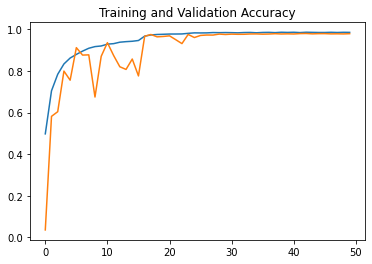

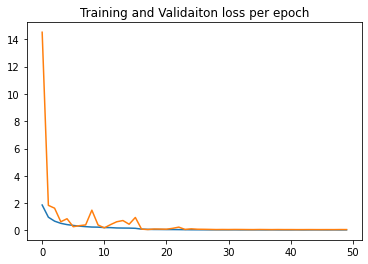

In [58]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

# Plot retrieved data
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title("Training and Validation Accuracy")

plt.figure()

plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title("Training and Validaiton loss per epoch")

# From the plots it can be seen that the model performs with an accuracy close to 1 and has next to 0 bias
# and almost 0 variance as well, which means it has regularized well.

In [59]:
# Print out the best 5 metrics
from statistics import mean
val_acc.sort()
val_loss.sort()
val_mae = history.history['val_mae']
val_mae.sort()
print("Top 5 validation loss: ", mean(val_loss[:5]))
print("Top 5 validation mean absolute error: ", mean(val_mae[:5]))
print("Top 5 validation accuracy: ", mean(val_acc[-4:]))

Top 5 validation loss:  0.06252917870879174
Top 5 validation mean absolute error:  0.001421006815508008
Top 5 validation accuracy:  0.9798999279737473


Check performance on validation set using the f1-score metric

In [0]:
# Get the model predictions on the val set
predictions_on_val_set = model.predict(x_val)

In [0]:
# Convert one-hot vectors to integer labels
val_set_answer = np.argmax(predictions_on_val_set, axis=1)
y_val = np.argmax(y_val, axis=1)

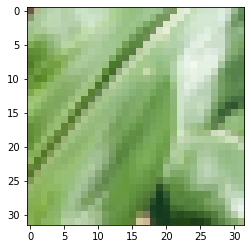

9


In [84]:
# Check one such prediction visually
plt.imshow(x_val[0])
plt.show()
print(val_set_answer[0])

In [86]:
from sklearn.metrics import f1_score
f1 = f1_score(y_val,val_set_answer,average='macro')
print(f1)

# f1-score turns out to be 0.9734730259091124, hence the model performs reasonably well on out-sample data

0.9734730259091124


Predictions on the test set(evaluation set for the competition)

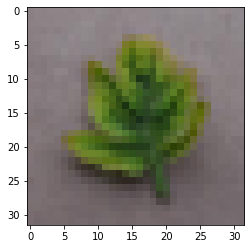

37


In [87]:
# Normalize the pixel values before predictions
test_images = test_images.astype(np.float32)/255.0

# Get the prediction
submission_one_hot = model.predict(test_images)

# Convert one-hot vectors to integer labels
submission = np.argmax(submission_one_hot, axis=1)

Save predictions to csv file

In [0]:
submission = pd.DataFrame(submission)
submission.to_csv('submission.csv',header=['class_index'],index=False)

Download generated csv(only for google colab environment)

In [0]:
from google.colab import files
files.download('submission.csv')